Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6829e129a0>>
Traceback (most recent call last):
  File "/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


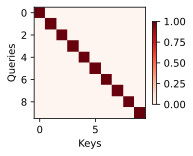

In [1]:
import torch
from d2l import torch as d2l

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows -1:
                ax.set_xlabel(xlabel)
            if j==0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
attention_weights = torch.eye(10).reshape((1,1,10,10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [ ]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

In [ ]:
def gaussian(x):
    return torch.exp(-x**2/2)

def boxcar(x):
    return torch.abs(x) <1.0

def constant(x):
    return 1.0+0*x

def epanechikov(x):
    return torch.max(1-torch.abs(x), torch.zeros_like(x))

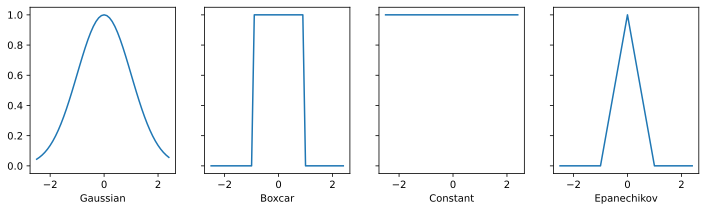

In [ ]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov') 
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy()) 
    ax.set_xlabel(name)
d2l.plt.show()


In [ ]:
def f(x):
    return 2*torch.sin(x)+x

n = 40
x_train, _ = torch.sort(torch.rand(n)*5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0,5,0.1)
y_val=f(x_val)

In [ ]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1,1)) - x_val.reshape((1,-1))
    k = kernel(dists).type(torch.float32)
    attention_w = k/k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

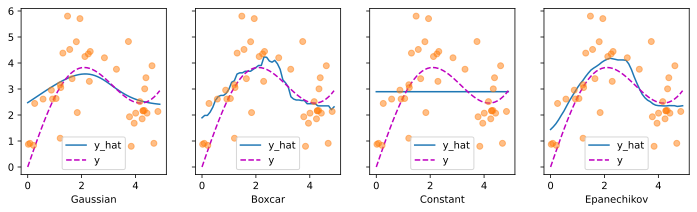

In [ ]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)
plot(x_train, y_train, x_val, y_val, kernels, names)

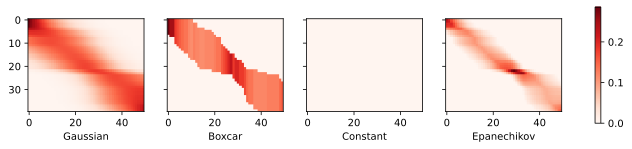

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

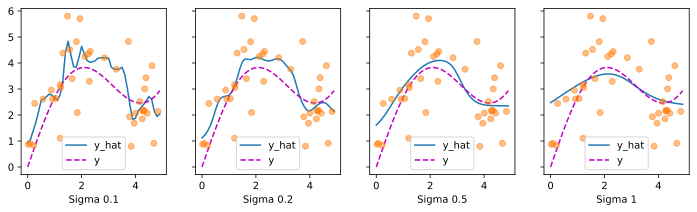

In [ ]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma '+str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2/(2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

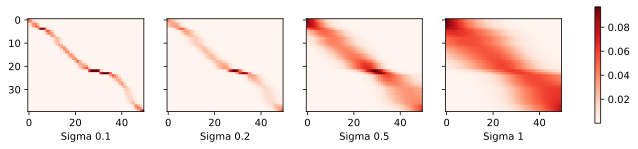

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

In [ ]:
import math
import torch 
from torch import nn
from d2l import torch as d2l

def masked_softmax(X, valid_lens):
    # Internal function _sequence_mask: Masks elements of X based on valid lengths.
    def _sequence_mask(X, valid_len, value=0):
        # maxlen: Get the size of the second dimension of X (sequence length).
        maxlen = X.size(1)
        # Create mask: Generate a mask array by comparing with each valid length.
        mask = torch.arange((maxlen), dtype=torch.float32, 
                            device=X.device)[None, :] < valid_len[:, None]
        # Set the values of X to 'value' where the mask is False.
        X[~mask] = value
        return X
    
    # If valid_lens is None, perform regular softmax.
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        # If valid_lens is 1D, repeat it for each sample.
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # If valid_lens is 2D, reshape it to 1D.
            valid_lens = valid_lens.reshape(-1)
        # Mask X using the _sequence_mask function.
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        # Perform softmax on the masked X.
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
masked_softmax(torch.randn(2, 2, 4), torch.tensor([2,3]))

tensor([[[0.2905, 0.7095, 0.0000, 0.0000],
         [0.6994, 0.3006, 0.0000, 0.0000]],

        [[0.6343, 0.1190, 0.2467, 0.0000],
         [0.3700, 0.3689, 0.2611, 0.0000]]])

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4153, 0.3506, 0.2341, 0.0000]],

        [[0.4864, 0.5136, 0.0000, 0.0000],
         [0.2133, 0.2792, 0.2812, 0.2263]]])

In [ ]:
Q = torch.ones((2,3,4))
K = torch.ones((2,4,6))
d2l.check_shape(torch.bmm(Q,K), (2,3,6))

In [ ]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout) # for model regularization
        
    def forward(self, queries, keys, values, valid_lens = None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2)) #mean, var, size
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

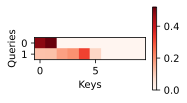

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [ ]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False) 
        self.W_q = nn.LazyLinear(num_hiddens, bias=False) 
        self.w_v = nn.LazyLinear(1, bias=False) 
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1) 
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
        

In [ ]:
queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval() 
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


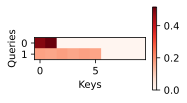

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)), xlabel='Keys', ylabel='Queries')

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class AttentionDecoder(d2l.Decoder):
    def __init__(self):
        super().__init__()
    @property
    def attention_weights(self):
        raise NotImplementedError

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout
        )
        self.dense=nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
        
    def init_state(self, enc_outputs, enc_valid_lens):
        outputs, hidden_state= enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1,0,2)
        outputs, self._attention_weights = [],[]
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state=self.rnn(x.permute(1,0,2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs,dim=0))
        return outputs.permute(1,0,2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2 
batch_size, num_steps = 4, 7 
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers) 
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers) 
X = torch.zeros((batch_size, num_steps), dtype=torch.long) 
state = decoder.init_state(encoder(X), None) 
output, state = decoder(X, state) 
d2l.check_shape(output, (batch_size, num_steps, vocab_size)) 
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens)) 
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


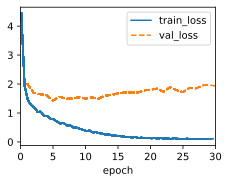

In [ ]:
data = d2l.MTFraEng(batch_size=128) 
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2 
encoder = d2l.Seq2SeqEncoder(
len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout) 
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .'] 
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 
preds, _ = model.predict_step( data.build(engs, fras), d2l.try_gpu(), data.num_steps) 
for en, fr, p in zip(engs, fras, preds):
    translation = [] 
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break 
        translation.append(token) 
    print(f'{en} => {translation}, bleu,' f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['elle', 'est', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


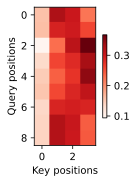

In [ ]:
_, dec_attention_weights = model.predict_step(data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1,1,-1, data.num_steps))

d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(), 
                  xlabel='Key positions', ylabel='Query positions')

In [ ]:
#11.3.1 Exercise
class Distance_Attention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout) # for model regularization
        
    def forward(self, queries, keys, values, valid_lens = None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)
        keys_norm = torch.sum(keys**2, dim=-1)/math.sqrt(d)
        scores = scores - keys_norm.unsqueeze(1)**0.5
        self.attention_weights=masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries = torch.normal(0, 1, (2, 1, 2)) #mean, var, size
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

In [ ]:
#11.3.2 Exercise
class Diff_Dim_Attention(nn.Module):
    def __init__(self, num_hiddens, dropout):
        super().__init__()
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.dropout = nn.Dropout(dropout) # for model regularization
        
    def forward(self, queries, keys, values, valid_lens = None):
        print("Before:", queries.shape)
        queries = self.W_q(queries) # adjust dimensions
        print("Modified:", queries.shape)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries = torch.normal(0, 1, (2, 1, 10))
keys = torch.normal(0, 1, (2, 10, 3))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = Diff_Dim_Attention(keys.shape[-1], dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape

Before: torch.Size([2, 1, 10])
Modified: torch.Size([2, 1, 3])


/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1, 4])

In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# class MultiHeadAttention(d2l.Module):
#     def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
#         super().__init__()
#         self.num_hiddens= num_heads
#         self.attention = d2l.DotProductAttention(dropout)
#         self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
#         self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
#         self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
#         self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
    
#     def forward(self, queries, keys, values, valid_lens):
#         queries = self.transpose_qkv(self.W_q(queries))
#         keys = self.transpose_qkv(self.W_k(keys))
#         values = self.transpose_qkv(self.W_v(values))
        
#         if valid_lens is not None:
#             # on axis 0, copy the first item for num heads times, then copy the next item. 
#             valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
#         output = self.attention(queries, keys, values, valid_lens)
#         output_concat = self.transpose_output(output)
#         return self.W_o(output_concat)

    # def transpose_qkv(self, X):
    #     # Shape of input X: (batch_size, no. of queries or key-value pairs, # num_hiddens).
    #     X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    #     # Shape of output X: (batch_size, no. of queries or # key-value pairs, num_heads, num_hiddens / num_heads)
    #     X = X.permute(0, 2, 1, 3) 
    #     # Shape of output X: (batch_size, num_heads, no. of queries or key-value # pairs, num_hiddens / num_heads)
    #     return X.reshape(-1, X.shape[2], X.shape[3])
    #     # Shape of output: (batch_size * num_heads, no. of queries or key-value # pairs, num_hiddens / num_heads)
        
    # def transpose_output(self, X):
    #     # Reverse the operation of transpose_qkv.
    #     X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    #     X = X.permute(0, 2, 1, 3)
    #     return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class MultiHeadAttention(d2l.Module): #@save
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__() 
        self.num_heads = num_heads 
        self.attention = d2l.DotProductAttention(dropout) 
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias) 
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias) 
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias) 
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries)) 
        keys = self.transpose_qkv(self.W_k(keys)) 
        values = self.transpose_qkv(self.W_v(values))
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave( valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = self.transpose_output(output) 
        return self.W_o(output_concat)

In [ ]:
@d2l.add_to_class(MultiHeadAttention) #@save 
def transpose_qkv(self, X):
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    X = X.permute(0, 2, 1, 3) 
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention) #@save 
def transpose_output(self, X): 
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2]) 
    X = X.permute(0, 2, 1, 3) 
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
num_hiddens, num_heads = 100, 5 
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5) 
batch_size, num_queries, num_kvpairs = 2, 4, 6 
valid_lens = torch.tensor([3, 2]) 
X = torch.ones((batch_size, num_queries, num_hiddens)) 
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens), (batch_size, num_queries, num_hiddens))

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
#11.6
import math 
import torch 
from torch import nn 
from d2l import torch as d2l

num_hiddens, num_heads = 100, 5 
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5) 
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2]) 
X = torch.ones((batch_size, num_queries, num_hiddens)) 
d2l.check_shape(attention(X, X, X, valid_lens), (batch_size, num_queries, num_hiddens))

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:,:,0::2]=torch.sin(X) #0부터 2번째씩 선택
        self.P[:,:,1::2]=torch.cos(X) #1부터 2번째씩 선택
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

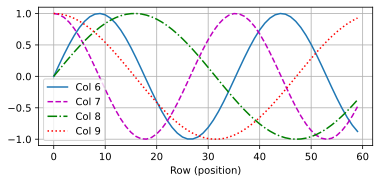

In [4]:
encoding_dim, num_steps = 32, 60 
pos_encoding = PositionalEncoding(encoding_dim, 0) 
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [5]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


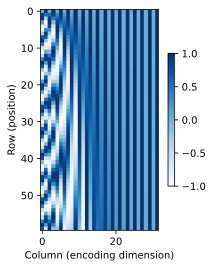

In [6]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

In [2]:
#11.7 Transformer

import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dens1=nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2=nn.LazyLinear(ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dens1(X)))
    

In [5]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2,3,4)))[0]

tensor([[-0.2778, -0.5636, -0.0938,  0.2946,  0.2439,  0.2370,  0.3997, -0.1867],
        [-0.2778, -0.5636, -0.0938,  0.2946,  0.2439,  0.2370,  0.3997, -0.1867],
        [-0.2778, -0.5636, -0.0938,  0.2946,  0.2439,  0.2370,  0.3997, -0.1867]],
       grad_fn=<SelectBackward0>)

In [6]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1,2], [2,3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y)+X)

In [8]:
add_norm = AddNorm(4, 0.5)
shape = (2,3,4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

In [10]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1=AddNorm(num_hiddens, dropout)
        self.ffn= PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2=AddNorm(num_hiddens, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [11]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding=d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks =nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))
        
    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights=[None]*len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [20]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5) 
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),(2, 100, 24))

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1=AddNorm(num_hiddens, dropout)
        self.attention2=d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn=PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # state[2][self.i] contains representations of the decoded output at # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps+1, device = X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [23]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0) 
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]] 
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [25]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state=blk(X, state)
            #decoder self attention
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            #enc-dec attention
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

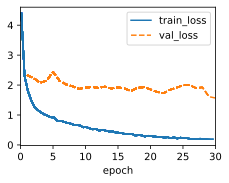

In [46]:
data = d2l.MTFraEng(batch_size=128) 
num_hiddens, num_blks, dropout = 256, 2, 0.2 
ffn_num_hiddens, num_heads = 64, 4 
encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,num_blks, dropout) 
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [47]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .'] 
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 
preds, _ = model.predict_step( data.build(engs, fras), d2l.try_gpu(), data.num_steps) 
for en, fr, p in zip(engs, fras, preds):
    translation = [] 
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break 
        translation.append(token) 
    print(f'{en} => {translation}, bleu,' f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [48]:
_, dec_attention_weights = model.predict_step( data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True) 
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0) 
shape = (num_blks, num_heads, -1, data.num_steps) 
enc_attention_weights = enc_attention_weights.reshape(shape) 
d2l.check_shape(enc_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps))

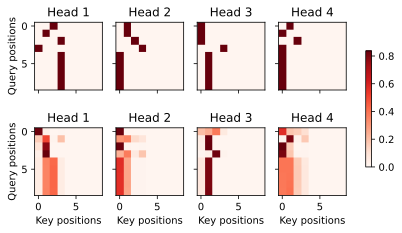

In [49]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize =(7,3.5)
)

In [50]:
dec_attention_weights_2d = [head[0].tolist() 
                            for step in dec_attention_weights 
                            for attn in step for blk in attn for head in blk] 
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values) 
shape = (-1, 2, num_blks, num_heads, data.num_steps) 
dec_attention_weights = dec_attention_weights_filled.reshape(shape) 
dec_self_attention_weights, dec_inter_attention_weights = \
dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps)) 
d2l.check_shape(dec_inter_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps))

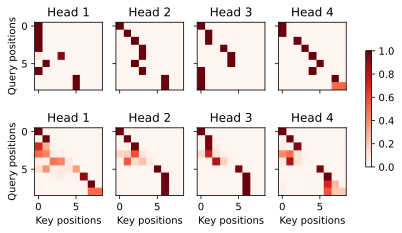

In [51]:
d2l.show_heatmaps(dec_self_attention_weights[:, :, :, :], xlabel='Key positions', ylabel='Query positions',
titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

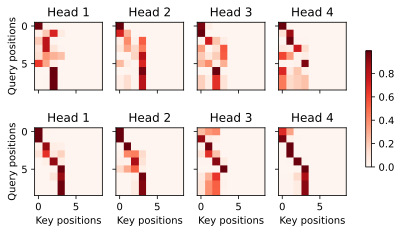

In [52]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions', 
                  ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x,(list, tuple)):
                return (x, x)
            return x 
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0]//patch_size[0])*(img_size[1]//patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)
    def forward(self, X):
        return self.conv(X).flatten(2).transpose(1, 2)

In [6]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X), (batch_size, (img_size//patch_size)**2, num_hiddens))

In [7]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1=nn.LazyLinear(mlp_num_hiddens)
        self.gelu=nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2=nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(x)))))

In [8]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1=nn.LayerNorm(norm_shape)
        self.attention=d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.ln2=nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)
        
    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)]*3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [9]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
class ViT(d2l.Classifier):
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, 
                emb_dropout, blk_dropout, lr=0.1, use_bias=False, num_classes=10):
        super().__init__() 
        self.save_hyperparameters() 
        self.patch_embedding = PatchEmbedding( img_size, patch_size, num_hiddens) 
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens)) 
        num_steps = self.patch_embedding.num_patches + 1 
        # Add the cls token # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter( torch.randn(1, num_steps, num_hiddens)) 
        self.dropout = nn.Dropout(emb_dropout) 
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock( 
                    num_hiddens, num_hiddens, mlp_num_hiddens, num_heads, blk_dropout, use_bias)) 
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens), nn.Linear(num_hiddens, num_classes))
    
    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding) 
        for blk in self.blks:
            X = blk(X) 
        return self.head(X[:, 0])

In [17]:
# modified for 11.8.7. exercise
def modified_forward(self, X):
        X = self.patch_embedding(X)
        X_mean = X.mean(dim=1, keepdim=True)
        X = torch.cat((X_mean, X), dim=1)
        X = self.dropout(X) 
        for blk in self.blks:
            X = blk(X) 
        return self.head(X[:, 0])

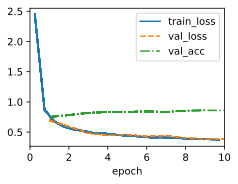

In [16]:
img_size, patch_size = 96, 16 
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2 
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1 
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size)) 
trainer.fit(model, data)